**OG code available at**

https://pytorch-geometric.readthedocs.io/en/2.2.0/notes/colabs.html
***

https://github.com/pyg-team/pytorch_geometric

install wheels for torch geometric, https://data.pyg.org/whl/

pyg-lib did not install for windows

pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.1%2Bcu121.html

pip install torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.1%2Bcu121.html

pip install torch-geometric


In [29]:
import networkx as nx
import matplotlib.pyplot as plt
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]

In [19]:
edge_index = data.edge_index
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

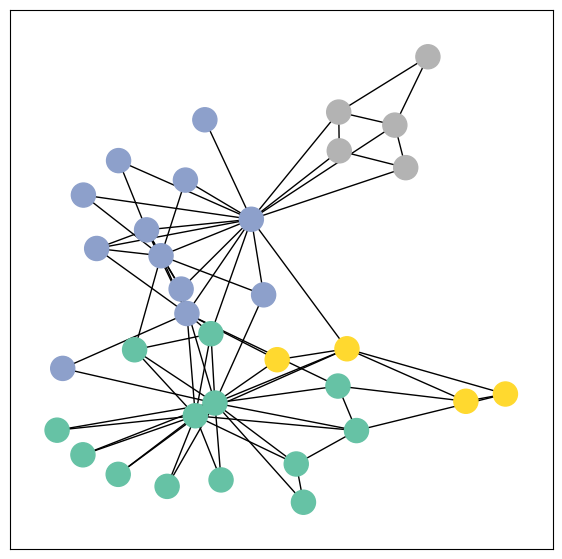

In [20]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [31]:
import torch, time
from torch_geometric.nn import GCNConv
import torch.nn as nn

In [32]:
class GCN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        torch.manual_seed(69)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4,4)
        self.conv3 = GCNConv(4,2)
        self.classifier = nn.Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = torch.tanh(self.conv1(x, edge_index))
        h = torch.tanh(self.conv2(h, edge_index))
        h = torch.tanh(self.conv3(h, edge_index))

        out = self.classifier(h)

        return out, h
    
model = GCN()
model


GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

torch.Size([34, 2])


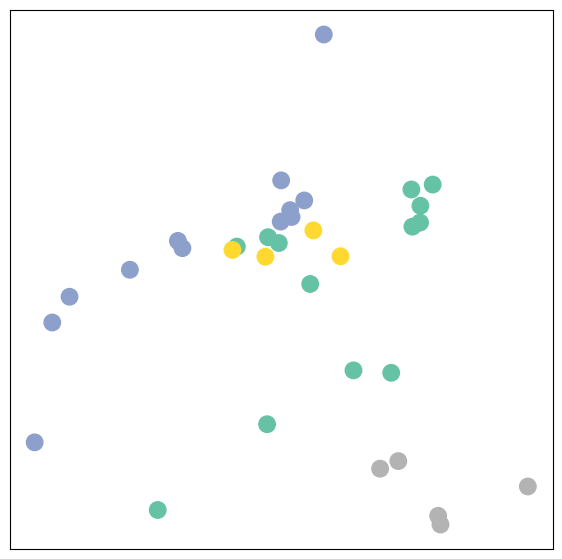

In [33]:
_, h  =  model(data.x, data.edge_index)
print(h.shape)
visualize_embedding(h, color=data.y)

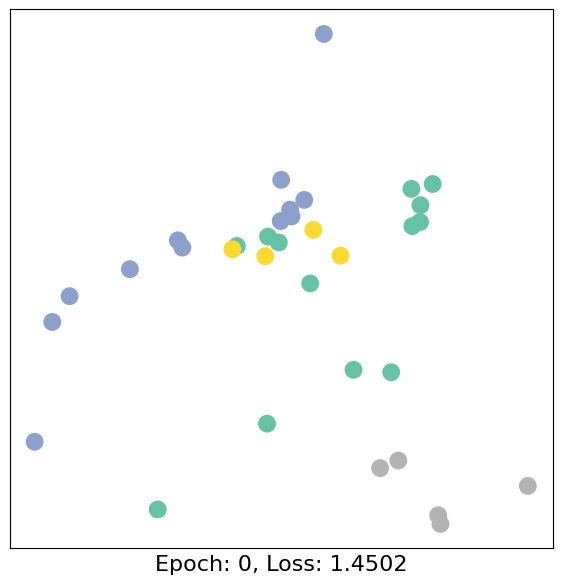

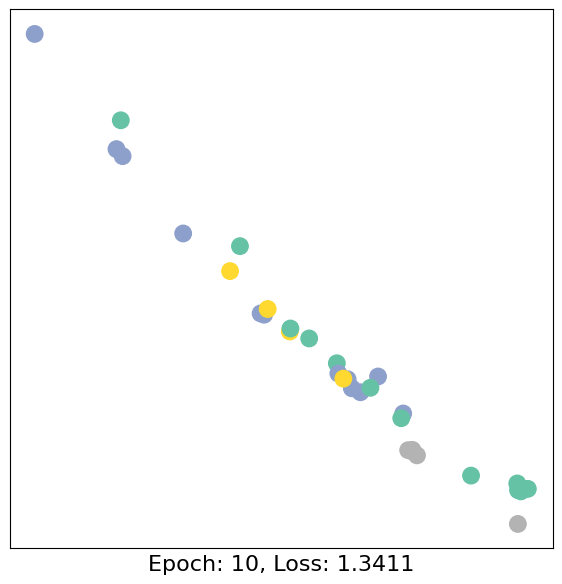

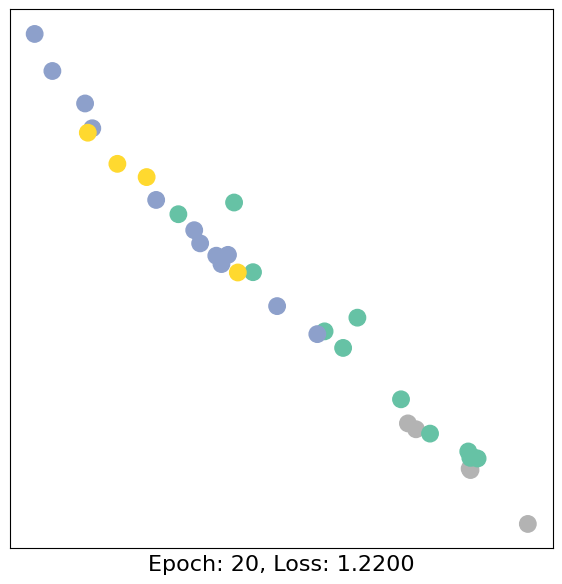

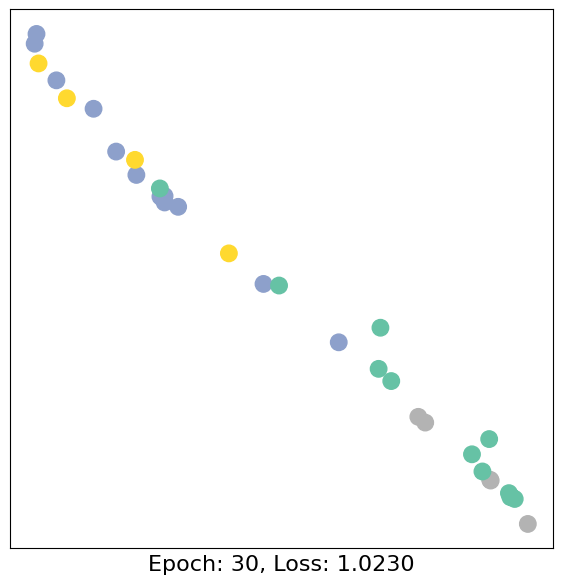

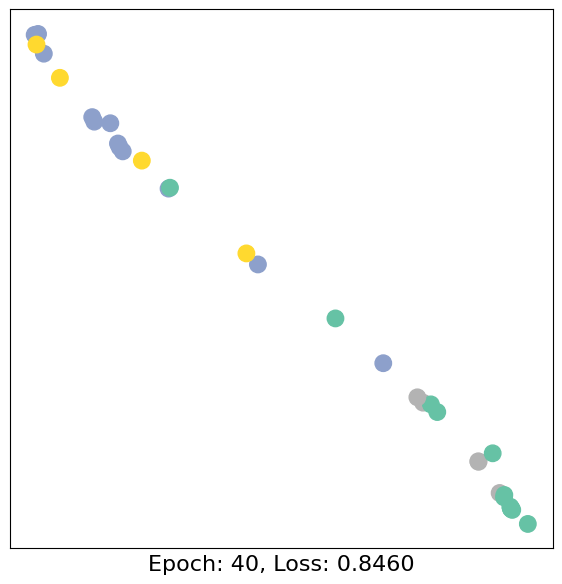

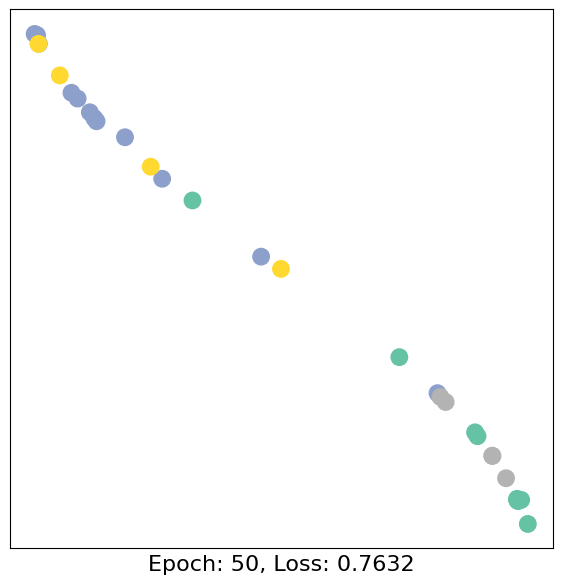

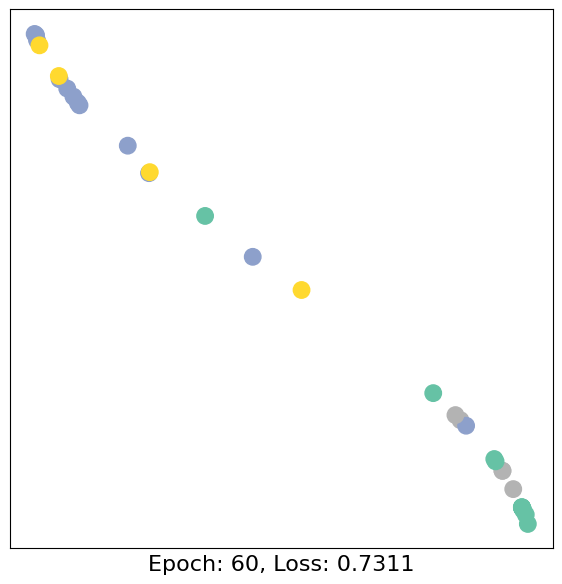

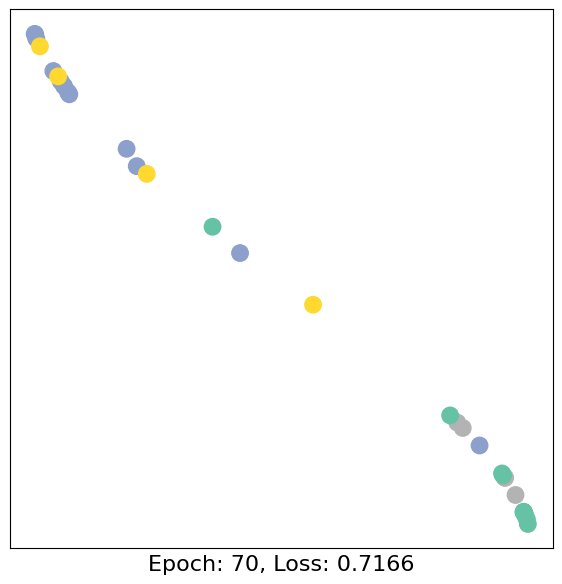

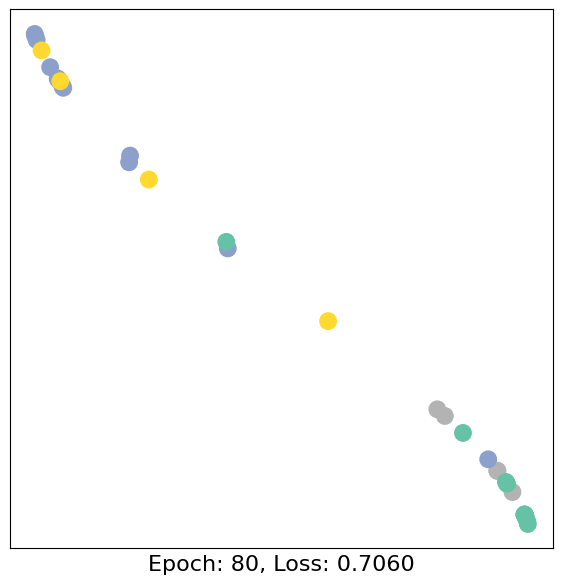

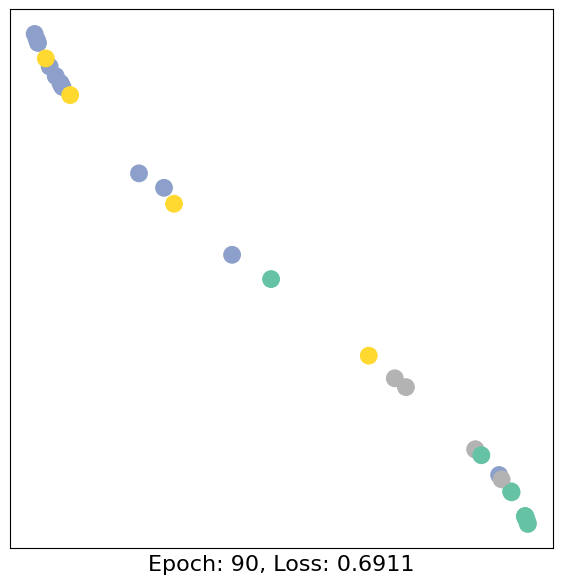

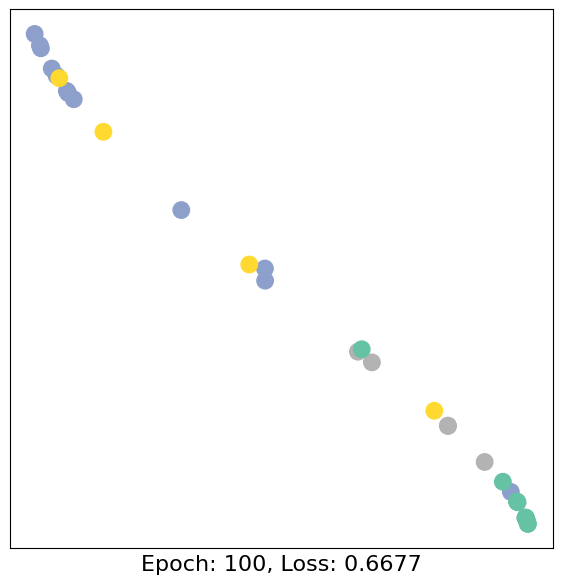

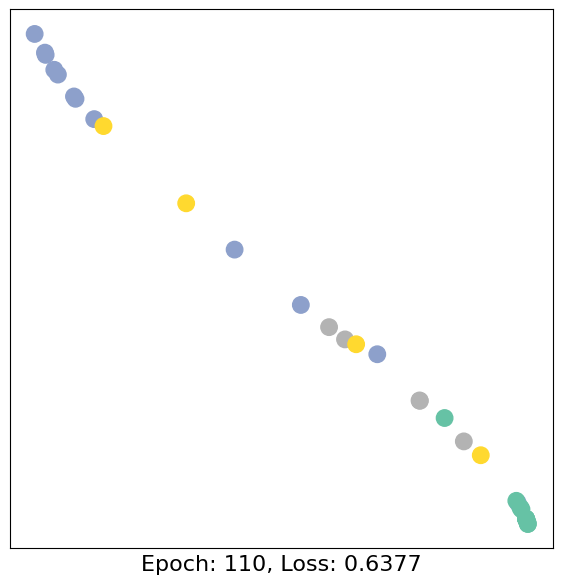

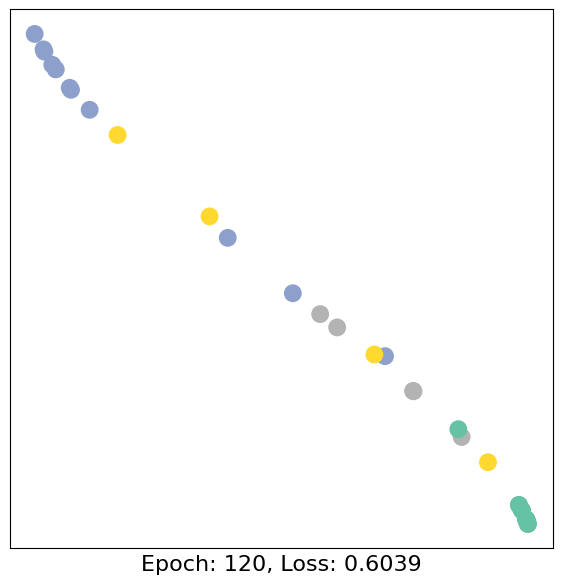

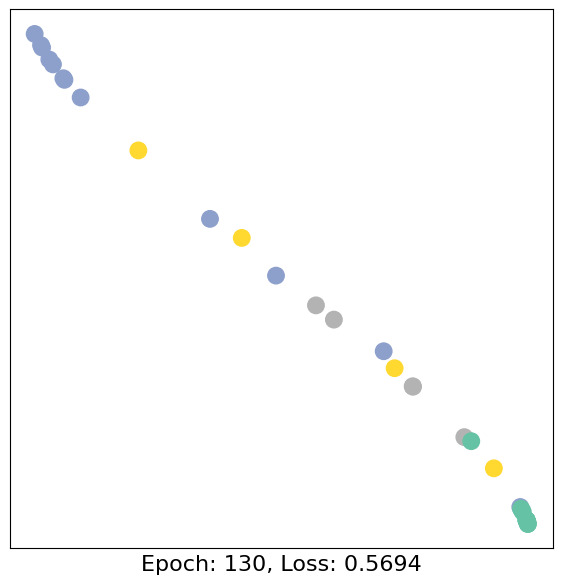

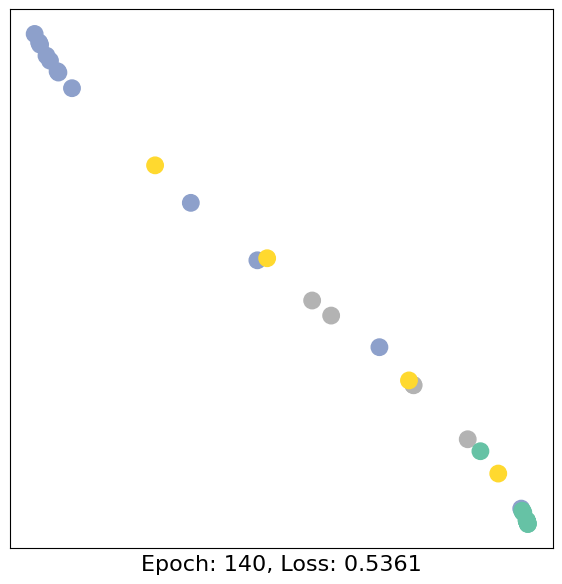

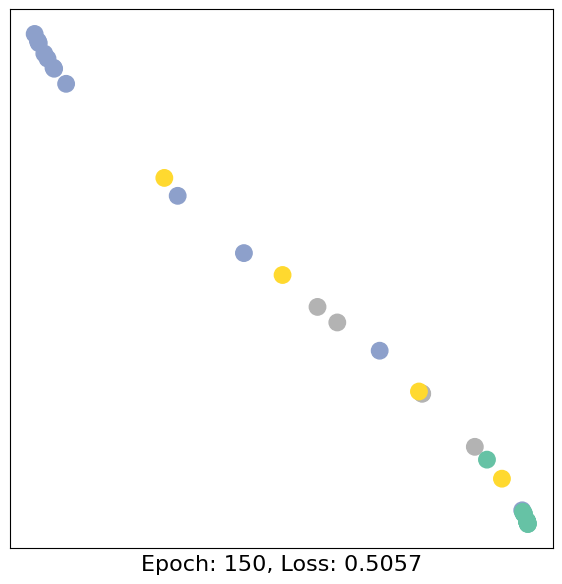

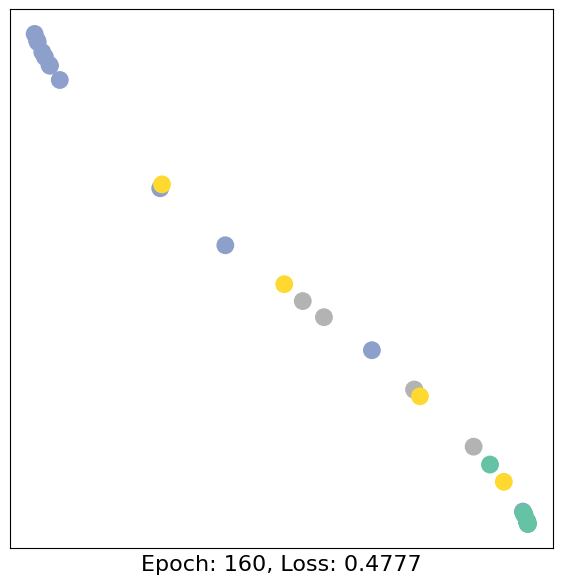

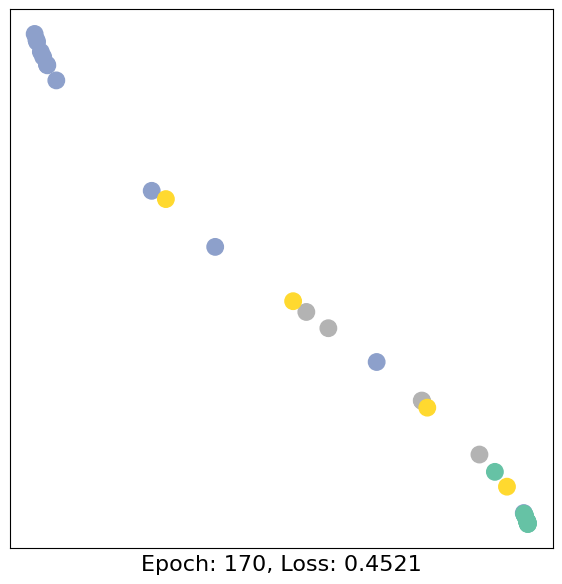

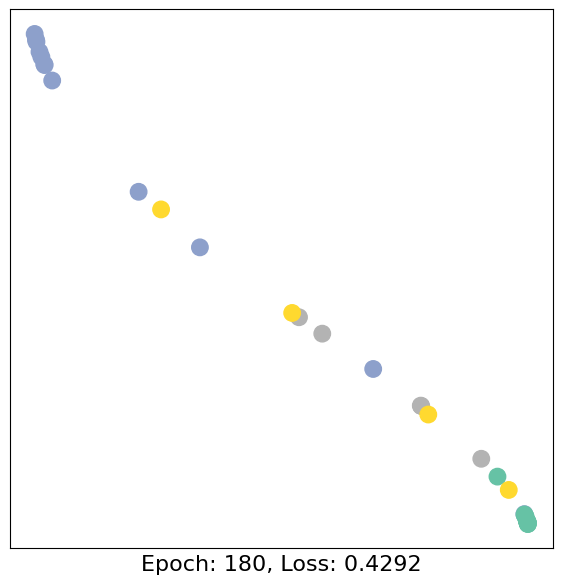

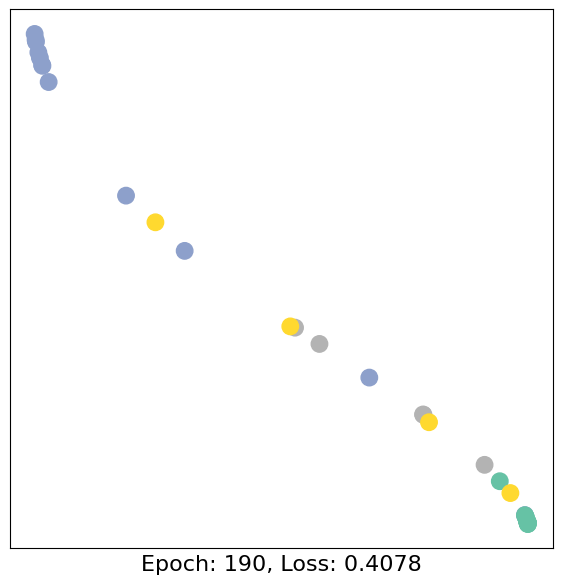

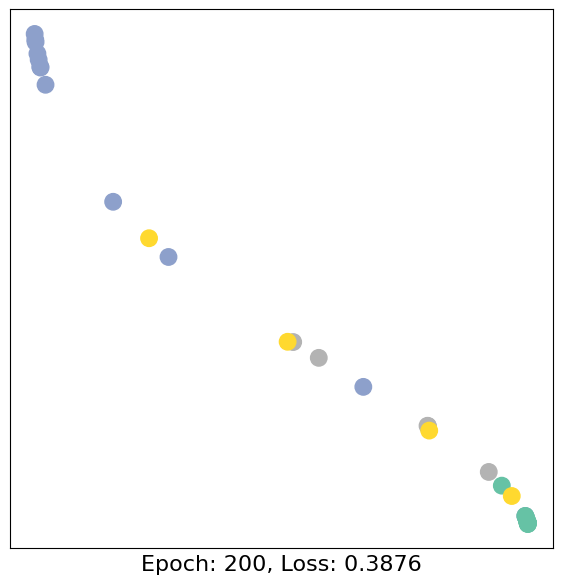

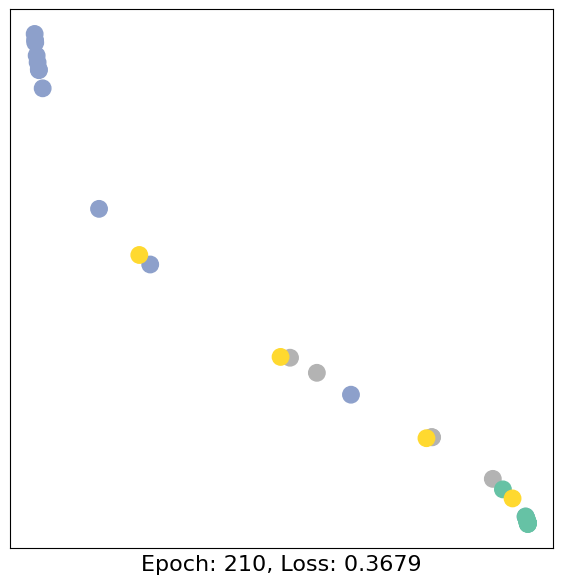

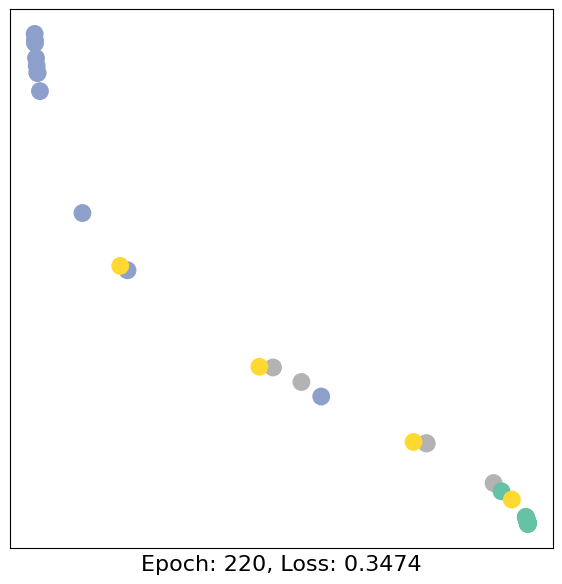

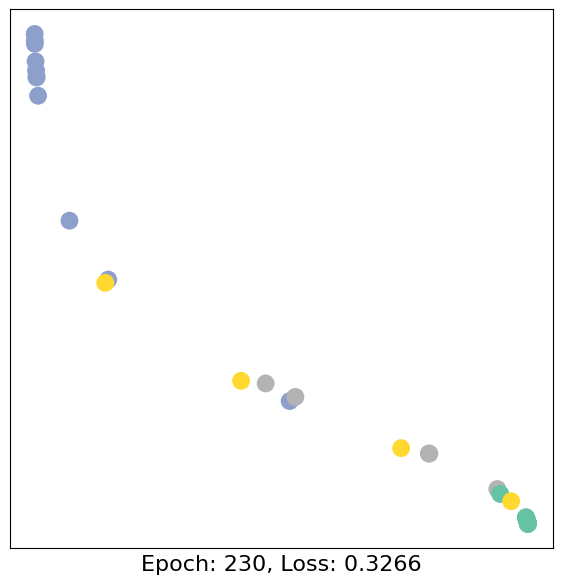

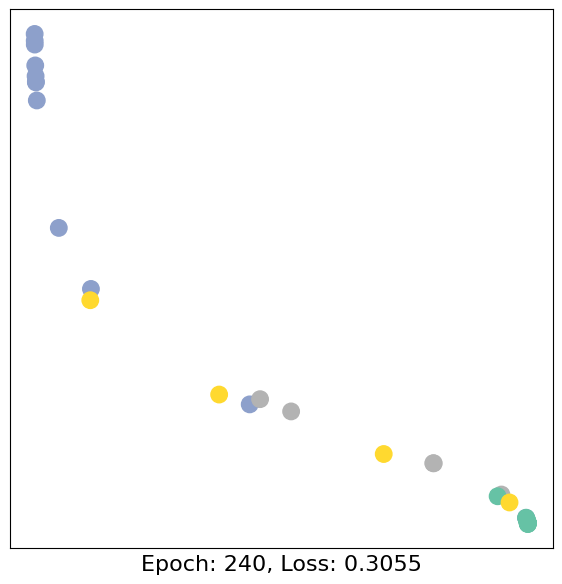

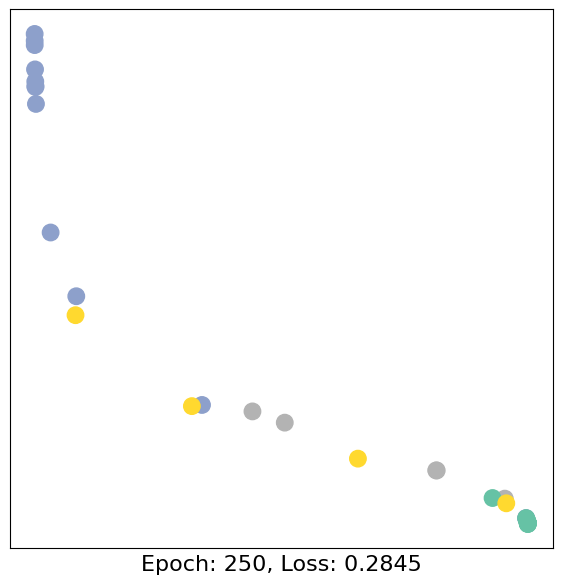

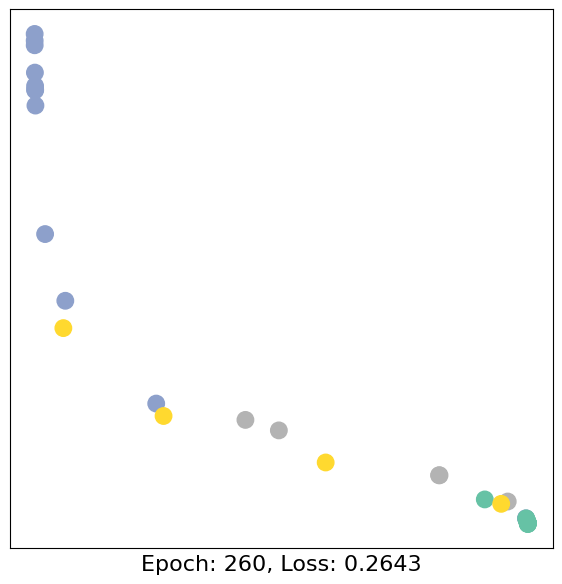

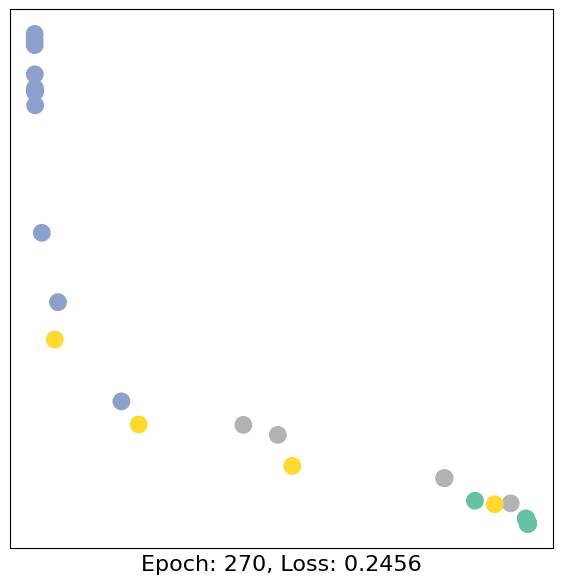

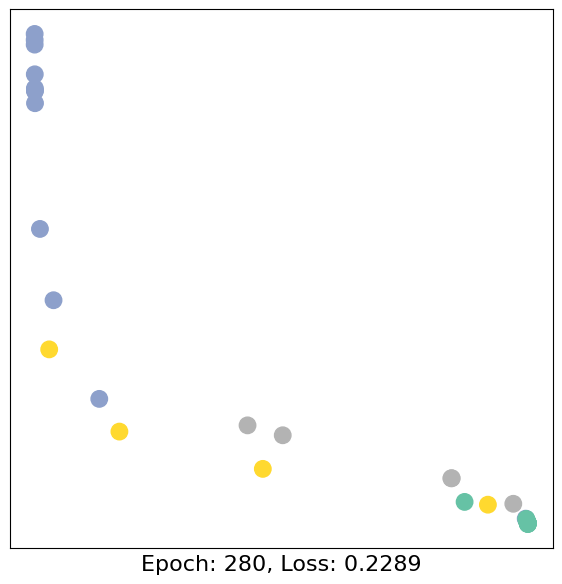

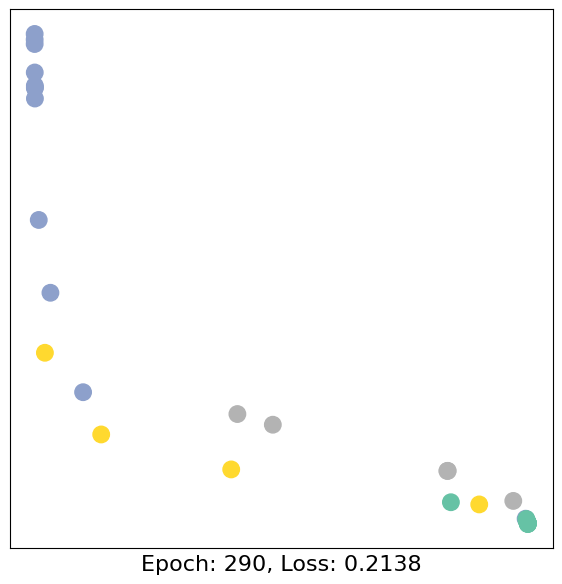

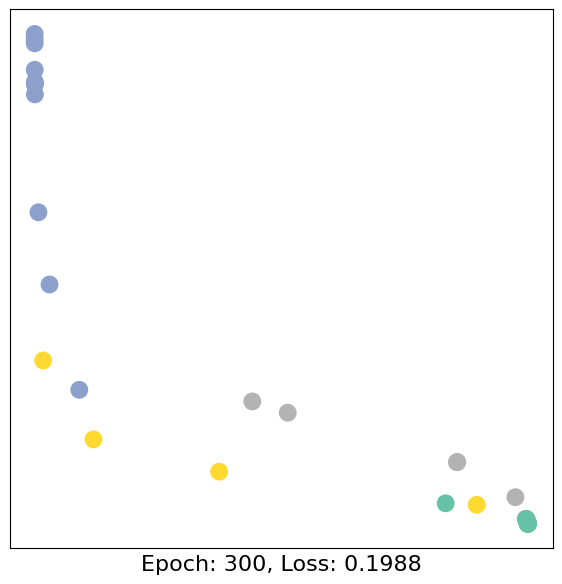

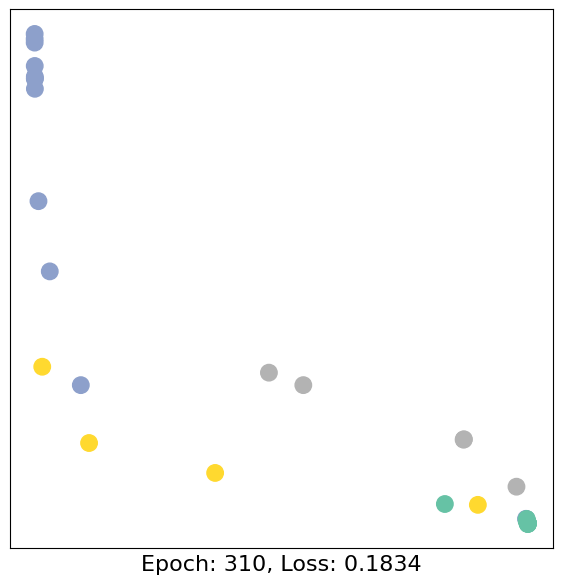

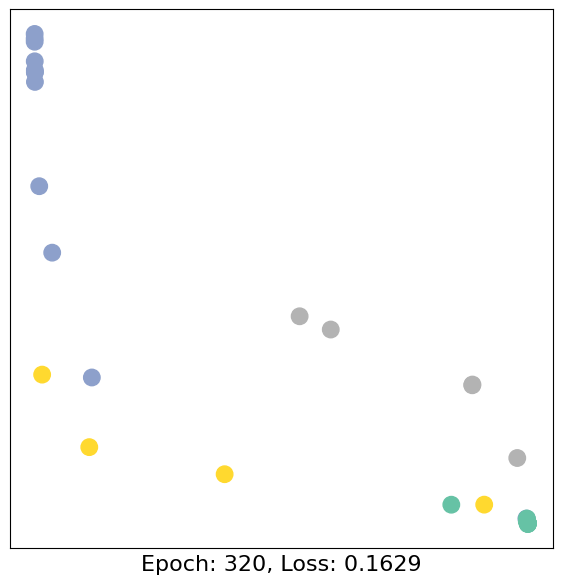

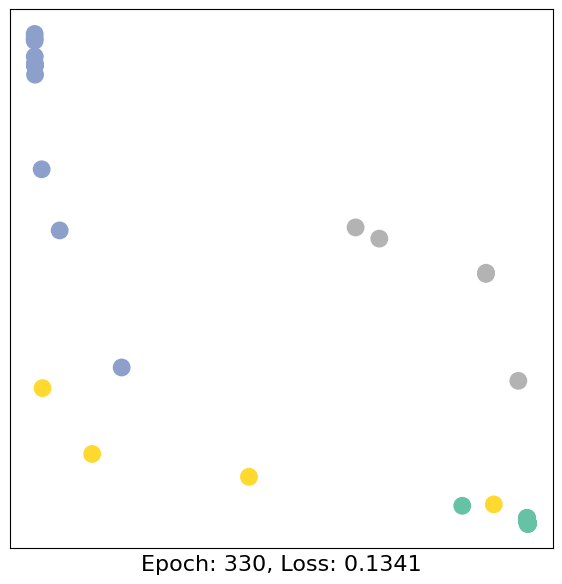

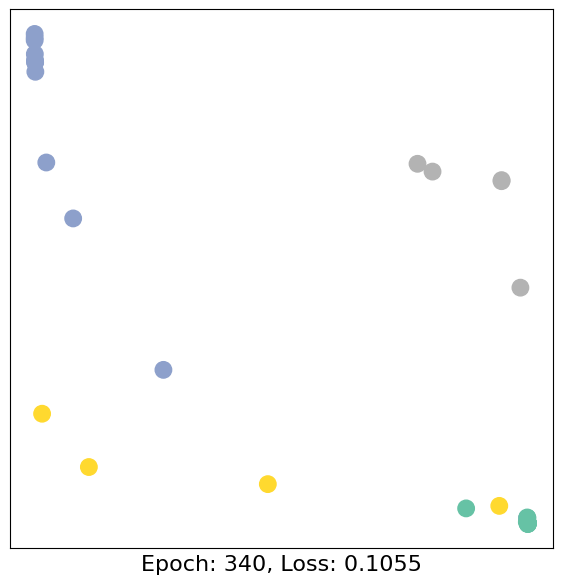

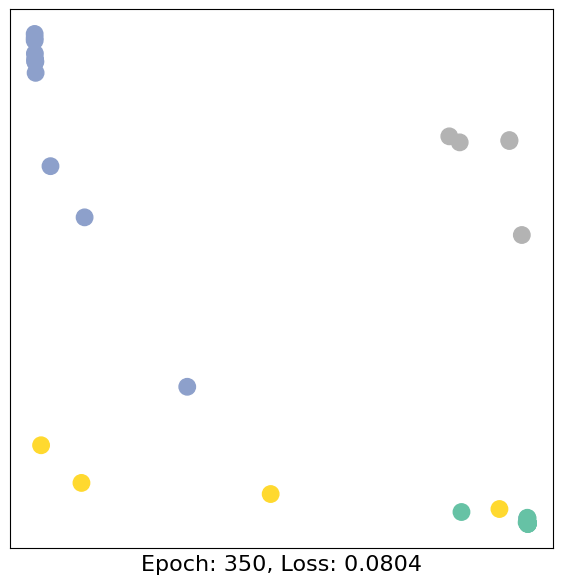

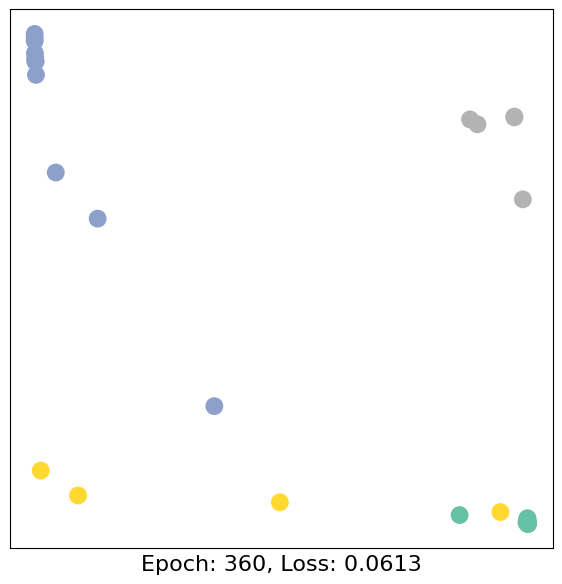

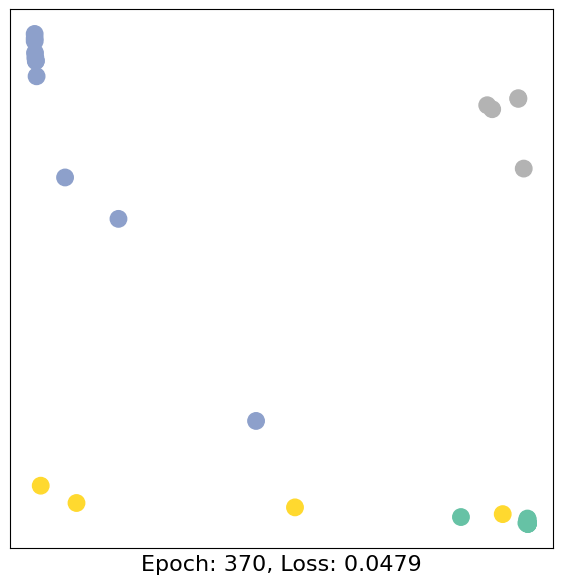

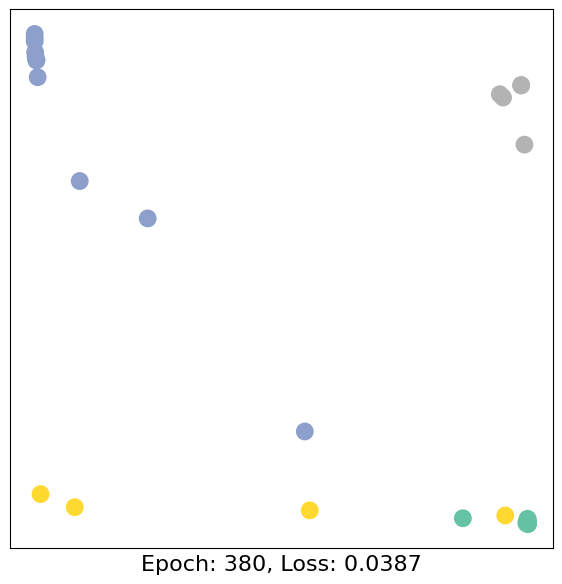

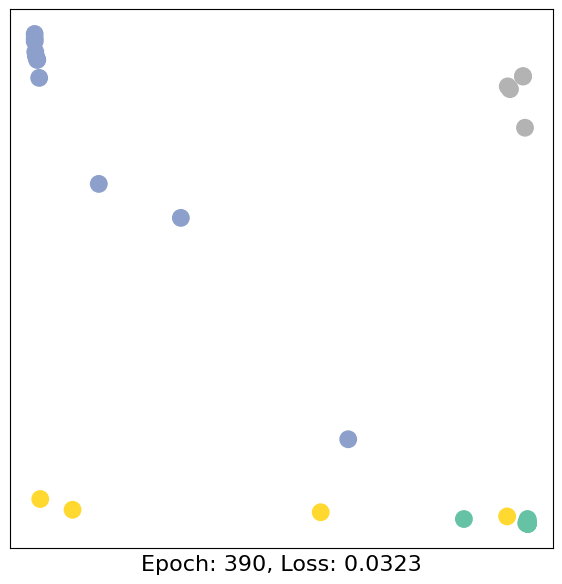

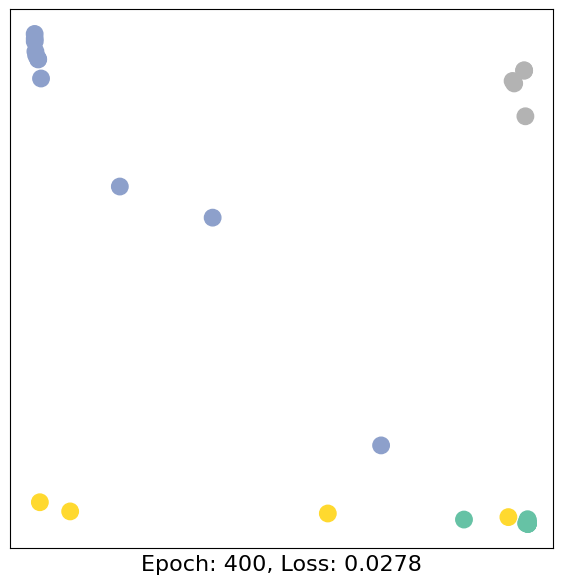

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

def train(data):
    optimizer.zero_grad()
    out,h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(401):
    loss,h = train(data)

    if epoch % 10 == 0:
        visualize_embedding(h, color = data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)